In [3]:
# Importing libraries

import os
import numpy as np
import time
import cv2
from PIL import Image
import glob
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import classification_report, confusion_matrix
from keras.utils import plot_model
from keras.utils.vis_utils import plot_model
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, SeparableConv2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf
from tensorflow.keras.preprocessing import image

In [4]:
# Input directory

input_path = 'C:/Users/Sanath/Desktop/COVID-19 Image Classification/Covid dataset'
num_covid = len(os.listdir(input_path + '/train/COVID/'))
num_normal = len(os.listdir(input_path + '/train/NORMAL/'))
num_pneumonia = len(os.listdir(input_path + '/train/Viral Pneumonia/'))
print('COVID: {} images, Normal: {} images, Pneumonia: {} images'.format(num_covid, num_normal, num_pneumonia))
print('Total images: {}'.format(num_covid + num_normal + num_pneumonia))

COVID: 800 images, Normal: 800 images, Pneumonia: 800 images
Total images: 2400


In [5]:
# Defining some constant variables to use in the preprocessor

train_path  = 'C:/Users/Sanath/Desktop/COVID-19 Image Classification/Covid dataset/train'
valid_path = 'C:/Users/Sanath/Desktop/COVID-19 Image Classification/Covid dataset/val'
test_path =  'C:/Users/Sanath/Desktop/COVID-19 Image Classification/Covid dataset/test'

IMAGE_SIZE    = (350, 350)
NUM_CLASSES   = 3 
BATCH_SIZE    = 32 
NUM_EPOCHS    = 20 

In [7]:
# Classes 

class_names =  ['COVID-19', 'Normal', 'Viral Pneumonia']
for i in range(len(class_names)):
    print(class_names[i]," " , i)

COVID-19   0
Normal   1
Viral Pneumonia   2


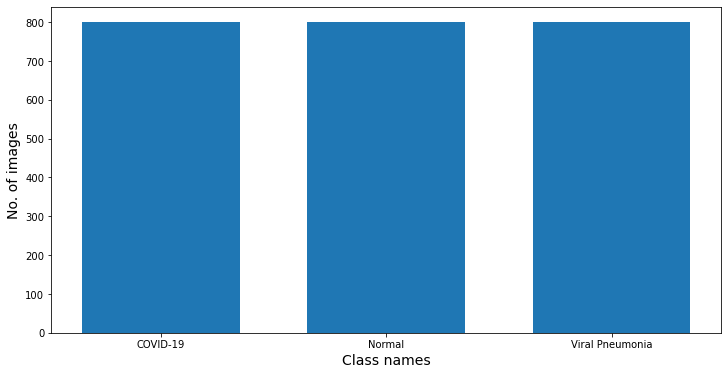

In [9]:
x = class_names
y = [num_covid, num_normal, num_pneumonia]
plt.figure(figsize=(12, 6))
plt.bar(x, y, width = 0.7)
plt.xlabel('Class names', fontsize = 14)
plt.ylabel('No. of images', fontsize = 14)
plt.show()

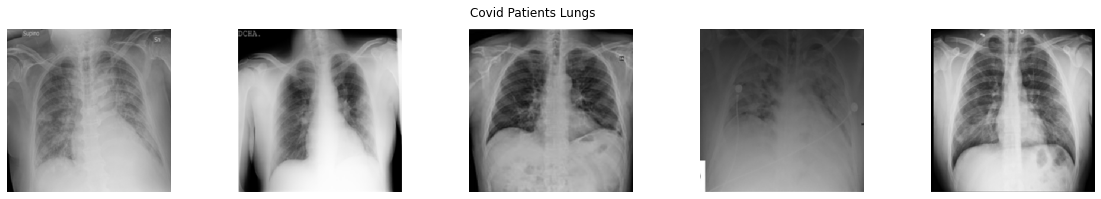

In [24]:
covid_images = []

for img_path in glob.glob(TRAIN_PATH + '/COVID/*'):
    covid_images.append(image.load_img(str(img_path), target_size = (350,350,3)))

fig = plt.figure(figsize=(20, 3))
fig.suptitle('Covid Patients Lungs')
for i in range(1, 6):
    fig.add_subplot(1, 5, i)
    plt.imshow(covid_images[i])
    plt.axis('off')

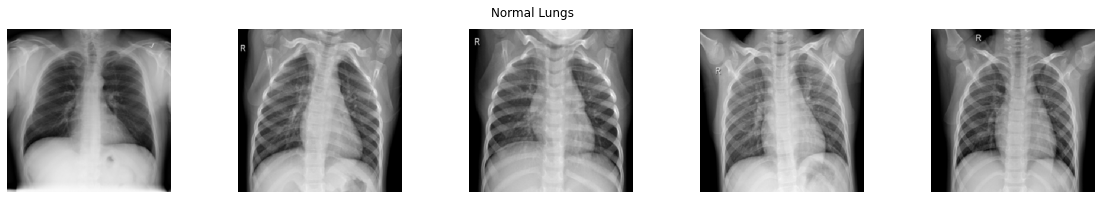

In [25]:
normal_images = []

for img_path in glob.glob(TRAIN_PATH + '/Normal/*'):
    normal_images.append(image.load_img(str(img_path), target_size = (350,350,3)))

fig = plt.figure(figsize=(20, 3))
fig.suptitle('Normal Lungs')
for i in range(1, 6):
    fig.add_subplot(1, 5, i)
    plt.imshow(normal_images[i])
    plt.axis('off')

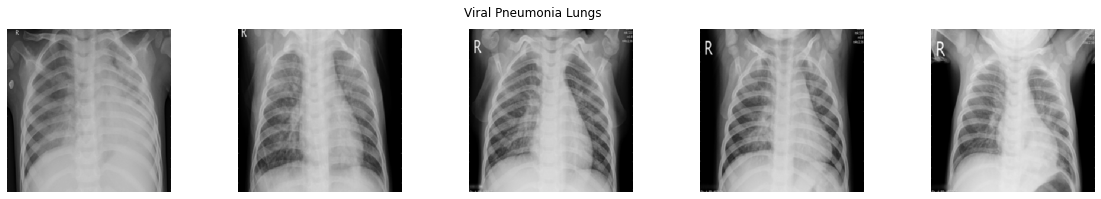

In [26]:
viral_images = []

for img_path in glob.glob(TRAIN_PATH + '/Viral Pneumonia/*'):
    viral_images.append(image.load_img(str(img_path), target_size = (350,350,3)))

fig = plt.figure(figsize=(20, 3))
fig.suptitle('Viral Pneumonia Lungs')
for i in range(1, 6):
    fig.add_subplot(1, 5, i)
    plt.imshow(viral_images[i])
    plt.axis('off')

In [10]:
# Train datagen here is a preprocessor

train_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip = False ,
                                   vertical_flip = False )

test_datagen = ImageDataGenerator(rescale = 1./255)

valid_datagen = ImageDataGenerator(rescale=1./255)

train_batches = train_datagen.flow_from_directory(train_path,
                                                  target_size = IMAGE_SIZE,
                                                  shuffle = True,
                                                  class_mode = 'categorical'
                                                  )

valid_batches = valid_datagen.flow_from_directory(valid_path,
                                                  target_size = IMAGE_SIZE,
                                                  shuffle = True,
                                                  class_mode = 'categorical'
                                                  )

test_batches = test_datagen.flow_from_directory(test_path,
                                                target_size = IMAGE_SIZE,
                                                shuffle = True,
                                                class_mode = 'categorical')

Found 2400 images belonging to 3 classes.
Found 600 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


In [12]:
# Define model

model = Sequential()
    
# Convolve block

model.add(Conv2D(8, kernel_size = (3, 3), activation = 'relu', padding = 'same', input_shape = (350,350, 3)))
model.add(MaxPooling2D(pool_size = (2, 2), strides = 2))
model.add(Conv2D(16, kernel_size = (5, 5), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2), strides = 2))
model.add(Flatten())
model.add(Dense(120, activation = 'relu'))
model.add(Dense(60, activation = 'relu'))
    
# Output layer

model.add(Dense(3, activation = 'softmax'))

In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 350, 350, 8)       224       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 175, 175, 8)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 171, 171, 16)      3216      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 85, 85, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 115600)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 120)               13872120  
_________________________________________________________________
dense_4 (Dense)              (None, 60)               

In [14]:
# Compile model

opt = Adam(lr = 0.001)
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])
    
# Defining callbacks

early_stop = EarlyStopping(patience = 5, monitor = 'val_accuracy')

In [15]:
# Fit model

start = time.time()
result = model.fit(train_batches, validation_data = valid_batches, callbacks=[early_stop], epochs = NUM_EPOCHS)
end = time.time()
print('Time taken to train the model in seconds: ', (end - start))

Epoch 1/20
75/75 [==============================] - 94s 1s/step - loss: 0.9515 - accuracy: 0.7738 - val_loss: 0.2199 - val_accuracy: 0.9200
Epoch 2/20
75/75 [==============================] - 96s 1s/step - loss: 0.2391 - accuracy: 0.9246 - val_loss: 0.2775 - val_accuracy: 0.9083
Epoch 3/20
75/75 [==============================] - 95s 1s/step - loss: 0.1259 - accuracy: 0.9633 - val_loss: 0.2220 - val_accuracy: 0.9200
Epoch 4/20
75/75 [==============================] - 96s 1s/step - loss: 0.0607 - accuracy: 0.9817 - val_loss: 0.2560 - val_accuracy: 0.9200
Epoch 5/20
75/75 [==============================] - 99s 1s/step - loss: 0.0613 - accuracy: 0.9842 - val_loss: 0.2518 - val_accuracy: 0.9267
Epoch 6/20
75/75 [==============================] - 97s 1s/step - loss: 0.0196 - accuracy: 0.9954 - val_loss: 0.3383 - val_accuracy: 0.9133
Epoch 7/20
75/75 [==============================] - 97s 1s/step - loss: 0.0187 - accuracy: 0.9937 - val_loss: 0.3312 - val_accuracy: 0.8867
Epoch 8/20
75/75 [==

In [16]:
print('Training Accuracy: ' + str(np.round(result.history['accuracy'][-1]*100,2)) + '%')
print('Validation Accuracy: '+ str(np.round(result.history['val_accuracy'][-1]*100,2)) + '%')

Training Accuracy: 99.33%
Validation Accuracy: 89.33%


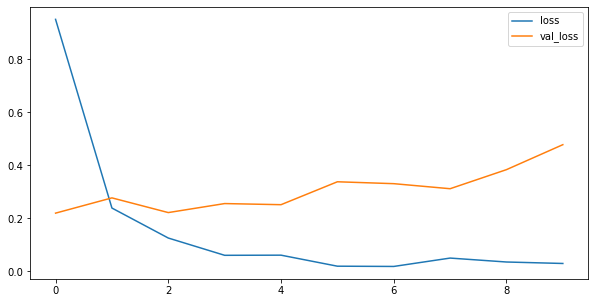

In [17]:
# Plotting train_loss vs val_loss

plt.figure(figsize = (10,5))
plt.plot(result.history['loss'], label = 'loss')
plt.plot(result.history['val_loss'], label = 'val_loss')
plt.legend()

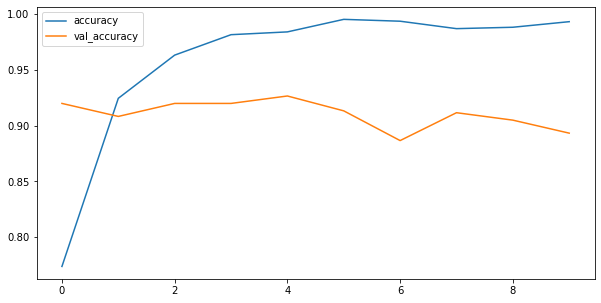

In [18]:
# Plotting train_accuracy vs Val_accuracy

plt.figure(figsize = (10,5))
plt.plot(result.history['accuracy'], label = 'accuracy')
plt.plot(result.history['val_accuracy'], label = 'val_accuracy')
plt.legend(loc = 'upper left')

In [19]:
test_loss , test_acc = model.evaluate(test_batches)
print('Test accuracy: {} and Test loss: {}'.format(test_acc, test_loss))

19/19 [==============================] - 8s 395ms/step - loss: 0.4715 - accuracy: 0.8817
Test accuracy: 0.8816666603088379 and Test loss: 0.4715224802494049


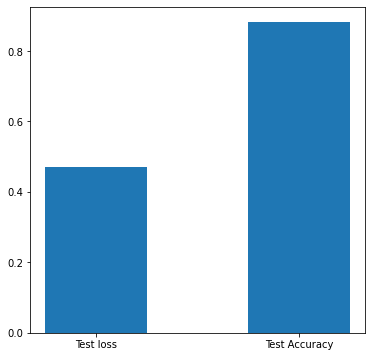

In [20]:
# Plotting test acc and test loss

x = ['Test loss', 'Test Accuracy']
y = [test_loss, test_acc]
plt.figure(figsize=(6,6))
plt.bar(x,y, width = 0.5)
plt.show()

In [21]:
model.save("model/Covid_19_CNN.h5")

In [22]:
# load the model we saved

from keras.models import load_model

model = load_model("model/Covid_19_CNN.h5")
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

In [23]:
model.get_weights()

[array([[[[-2.41096914e-01,  6.53404370e-02,  6.05302304e-02,
           -1.09531172e-01,  7.90040642e-02,  2.42532611e-01,
           -1.51666343e-01, -2.26232365e-01],
          [ 1.72915101e-01,  1.63995460e-01,  2.53964663e-01,
           -1.31339386e-01,  1.22440532e-01,  2.62005180e-01,
           -9.49262679e-02,  7.43827671e-02],
          [ 1.42359119e-02,  2.25194708e-01,  4.07650098e-02,
            5.41853681e-02,  7.18805045e-02,  1.73139155e-01,
            9.51493233e-02,  2.29596317e-01]],
 
         [[ 2.19934240e-01, -2.11612687e-01,  9.62914154e-02,
           -2.60149002e-01,  1.92082465e-01,  2.28141472e-01,
           -2.13018224e-01, -5.39642759e-04],
          [-8.13503265e-02, -2.13238239e-01,  2.19007254e-01,
           -4.99472842e-02,  2.22962528e-01, -9.91779715e-02,
            9.63523537e-02, -2.02594548e-01],
          [ 1.15460411e-01,  1.94111228e-01,  1.29990816e-01,
           -2.35617220e-01, -2.22956181e-01,  6.79706410e-02,
            3.86995114e

In [25]:
# Prediction of the images

from keras.preprocessing import image
img = image.load_img('C:/Users/Sanath/Desktop/COVID-19 Image Classification/Covid dataset/test/Viral Pneumonia/Viral Pneumonia-1017.png', target_size = (350, 350, 3))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
images = np.vstack([x])
prediction = model.predict_classes(images)
print("Predicted class is: ", class_names[int(prediction)])

Predicted class is:  Viral Pneumonia
